### Predicting Donor Excitement (KDD Cup 2014)

For the 2014 KDD Cup, participants were tasked with helping DonorsChoose.org, an online charity that makes it easy to help students in need through school donations, to identify "exciting" projects at the time of posting. Although all projects serve the needs of stuents and schools, some projects are exceptional and can provide a better outcome when successfully funded. The goal is to identify exceptional projects early in order to improve funding, user experience and help educators obtain the materials needed for better pedagogy.

"Exciting" projects are defined by meeting all of the follow criteria:  
- was fully funded (fully_funded)
- had at least one teacher-acquired donor (at_least_1_teacher_referred_donor)
- has a higher than average percentage of donors leaving an original message (great_chat)
- has at least one "green" donation (at_least_1_green_donation)
- has one or more of:
    - donations from three or more non teacher-acquired donors (three_or_more_non_teacher_referred_donors)
    - one non teacher-acquired donor gave more than $100 (one_non_teacher_referred_donor_giving_100_plus)
    - the project received a donation from a "thoughtful donor" 
    (donation_from_thoughtful_donor)  
    
To figure out what projects seem "exciting" to a potential donor, I visited DonorChoose.org to view project profiles and tried to get an idea of why potential donors may or may not fund a certain project. Machine learning aside, I have a feeling that the teacher proposing the project, whether he/she has a proven record of getting funded (much like research grants), has the greatest effect on making an project "exciting". 


### Exploratory analysis and data story

<p>
  
</p>
<body>
  
Let's examine the data to do some exploratory analysis. The data is provided in a relational format and there are six csv files in total.

<p>
1.donations.csv - contains information about the donations to each project. This is only provided for projects in the training set.  

2. essays.csv - contains project text posted by the teachers. This is provided for both the training and test set.  


3. projects.csv - contains information about each project. This is provided for both the training and test set.  


4. resources.csv - contains information about the resources requested for each project. This is provided for both the training and test set.  


5. outcomes.csv - contains information about the outcomes of projects in the training set.  


6. sampleSubmission.csv - contains the project ids of the test set and shows the submission format for the competition.  
</p>
</body>

In [1]:
import sys
sys.version

'3.5.2 |Anaconda 4.1.1 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]'

#### Functions used

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import time
from datetime import datetime

%matplotlib inline

In [76]:
def histcompareplots(df, feature):
    """ Compare continuous differences between exciting and non-exciting projects
    
    Input:
        1. df - dataframe containing all the data points and features
        2. feature - list of features to be compared 
        
    Output:
        1. Overlaid histogram plots of for each feature
        
    """
    a = time.time()
    
    # split into normal and abnormal data frames
    ex = df[df["is_exciting"] == "t"]
    noex = df[df["is_exciting"] == "f"]
    
    fignum = 1 # counter for number of plots 
    for feat in feature:
        plt.figure()
        plt.ylabel("Counts")
        plt.xlabel(feat)
        # bins = np.linspace(min(df[feat]), 1, 100).tolist() + np.linspace(1, max(df[feat]), 100).tolist()
        ex[feat].plot.hist(alpha = 0.5)
        noex[feat].plot.hist(alpha = 0.5)
        plt.yscale("log")
        plt.legend(["exciting", "non-exciting"])
        plt.title("Comparision of %s between exciting and non-exciting projects \n" %feat)        

        fignum = fignum + 1
        
    return

In [28]:
def boxplot(df, feature, scale="log"):
    """ Show boxplots of continuous features with data points 
        
    Input:
        1. df - dataframe containing all features and data points
        2. feature - list of features to be examined
        3. scale - log scale used for x-axis of box plot by default
    
    Output:
        1. Box plot on a log scale
    
    """
    ax = sns.boxplot(df[feature])
    sns.stripplot(df[feature])
    ax.set_xscale(scale)
    ax.set_xlim(left = 0)
    
    return

In [8]:
%%time
dondf = pd.read_csv("donations.csv")

Wall time: 3min 19s


In [3]:
%%time
essaydf = pd.read_csv("essays.csv")

Wall time: 1min 54s


In [4]:
%%time
projdf = pd.read_csv("projects.csv")

Wall time: 33.7 s


In [5]:
%%time
resdf = pd.read_csv("resources.csv")

Wall time: 1min 25s


In [6]:
%%time
outdf = pd.read_csv("outcomes.csv")

Wall time: 24 s
Compiler : 250 ms


In [7]:
%%time
submitdf = pd.read_csv("sampleSubmission.csv")

Wall time: 3.35 s


In [21]:
pd.options.display.max_columns = 50 # display more columns
dondf.head()

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message
0,431d720bc3dfd75ae445a5eaa0b0638d,ffffac55ee02a49d1abc87ba6fc61135,22cbc920c9b5fa08dfb331422f5926b5,Peachtree City,GA,30269.0,f,2011-08-25 14:27:34.807,42.50,7.50,50.00,10_to_100,t,no_cash_received,f,t,f,f,f,f,I gave to this project because I support the e...
1,fcfedba1c8a0ba77d280cace80a909f6,ffffac55ee02a49d1abc87ba6fc61135,521f1830a77c9dbbf8119d99c6206a16,NaN,GA,NaN,f,2011-11-04 07:54:21.552,26.83,4.73,31.56,10_to_100,t,creditcard,f,t,f,f,f,f,I donated because I want to support kids in Ge...
2,3fa95d29986aa6f401c6719ced3a3ce7,ffffac55ee02a49d1abc87ba6fc61135,1e0a63fc8141c7ba26b8b44ca0871b90,Rockville,MD,20853.0,f,2011-11-02 22:53:53.019,55.35,0.00,55.35,10_to_100,f,no_cash_received,t,f,f,f,t,f,The Spark's 'pet' projects include those which...
3,020ad6bd5e88a35741d23b5e08f8b8e8,ffffac55ee02a49d1abc87ba6fc61135,1d4acb508df29d5f1cc6d382969576cb,Salem,IN,47167.0,f,2011-11-03 23:54:01.109,8.50,1.50,10.00,10_to_100,t,paypal,f,f,f,f,f,f,I gave to this project because Education is im...
4,4b44b03f304d6425ae94446686f93cd6,ffffac55ee02a49d1abc87ba6fc61135,59c3c3cfcccc53ae855f7eee911c478b,anonymous,NaN,0.0,f,2011-11-02 23:21:00.043,20.00,0.00,20.00,10_to_100,f,no_cash_received,f,f,t,f,t,f,I lent a paw to help the children in this clas...


In [9]:
dondf.describe() # negative min donation amount?

C:\Users\XX\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,donor_zip,donation_to_project,donation_optional_support,donation_total
count,1.385927e+06,3.097989e+06,3.097989e+06,3.097989e+06
mean,5.066494e+04,6.594590e+01,1.073131e+01,7.667691e+01
std,3.331468e+04,2.379026e+02,3.688343e+01,2.704941e+02
min,0.000000e+00,-1.275000e+01,-2.250000e+00,-1.500000e+01
25%,NaN,1.000000e+01,1.500000e+00,1.000000e+01
50%,NaN,2.125000e+01,3.750000e+00,2.500000e+01
75%,NaN,5.000000e+01,7.500000e+00,5.611000e+01
max,9.999900e+04,1.472040e+05,2.199600e+04,1.692000e+05


In [26]:
essaydf.head()

,projectid,teacher_acctid,title,short_description,need_statement,essay
0,ffffc4f85b60efc5b52347df489d0238,c24011b20fc161ed02248e85beb59a90,iMath,It is imperative that teachers bring technolog...,My students need four iPods.,I am a fourth year fifth grade math teacher. T...
1,ffffac55ee02a49d1abc87ba6fc61135,947066d0af47e0566f334566553dd6a6,Recording Rockin' Readers,Can you imagine having to translate everything...,My students need a camcorder.,Can you imagine having to translate everything...
2,ffff97ed93720407d70a2787475932b0,462270f5d5c212162fcab11afa2623cb,Kindergarten In Need of Important Materials!,It takes a special person to donate to a group...,My students need 17 assorted classroom materia...,Hi. I teach a wonderful group of 4-5 year old ...
3,ffff7266778f71242675416e600b94e1,b9a8f14199e0d8109200ece179281f4f,Let's Find Out!,My Kindergarten students come from a variety o...,"My students need 25 copies of Scholastic's ""Le...",My Kindergarten students come from a variety o...
4,ffff418bb42fad24347527ad96100f81,e885fb002a1d0d39aaed9d21a7683549,Whistle While We Work!,"By using the cross curricular games requested,...",My students need grade level appropriate games...,All work and no play makes school a dull place...


In [10]:
essaydf.describe()

,projectid,teacher_acctid,title,short_description,need_statement,essay
count,664098,664098,664081,663966,662626,664095
unique,664098,249555,570117,641701,639965,662831
top,06a49c55f4faa135b4cdf18951db0dad,787720cc575e3204991b8ca18d312d2b,Can You Hear Me Now?,Do you remember what it was like the first tim...,My students need a document camera.,I am a K-5 general music teacher at Vinson-Byn...
freq,1,266,574,144,769,16


In [22]:
projdf.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted
0,316ed8fb3b81402ff6ac8f721bb31192,42d43fa6f37314365d08692e08680973,c0e6ce89b244764085691a1b8e28cb81,6.362701e+10,36.576340,-119.608713,Selma,CA,93662.0,NaN,Selma Unified Sch District,Fresno,f,f,f,f,f,f,Mrs.,f,f,Literature & Writing,Literacy & Language,College & Career Prep,Applied Learning,Books,highest poverty,Grades 6-8,30.0,555.81,653.89,32.0,f,f,2014-05-12
1,90de744e368a7e4883223ca49318ae30,864eb466462bf704bf7a16a585ef296a,d711e47810900c96f26a5d0be30c446d,4.837020e+11,32.911179,-96.723640,Dallas,TX,75243.0,urban,Richardson Ind School District,Dallas,f,f,f,f,f,f,Mrs.,f,f,Literacy,Literacy & Language,ESL,Literacy & Language,Books,highest poverty,Grades PreK-2,30.0,296.47,348.79,22.0,f,f,2014-05-12
2,32943bb1063267de6ed19fc0ceb4b9a7,37f85135259ece793213aca9d8765542,665c3613013ba0a66e3a2a26b89f1b68,4.103270e+11,45.166039,-122.414576,Colton,OR,97017.0,rural,Colton School District 53,Clackamas,f,f,f,f,f,f,Mr.,f,f,Literacy,Literacy & Language,Mathematics,Math & Science,Technology,high poverty,Grades PreK-2,30.0,430.89,506.93,17.0,f,f,2014-05-11
3,bb18f409abda2f264d5acda8cab577a9,2133fc46f951f1e7d60645b0f9e48a6c,4f12c3fa0c1cce823c7ba1df57e90ccb,3.600153e+11,40.641727,-73.965655,Brooklyn,NY,11226.0,urban,New York City Dept Of Ed,Kings (Brooklyn),f,t,f,f,f,f,Mr.,t,f,Social Sciences,History & Civics,Special Needs,Special Needs,Books,highest poverty,Grades 3-5,30.0,576.07,677.73,12.0,f,f,2014-05-11
4,24761b686e18e5eace634607acbcc19f,867ff478a63f5457eaf41049536c47cd,10179fd362d7b8cf0e89baa1ca3025bb,6.227100e+10,34.043939,-118.288371,Los Angeles,CA,90006.0,urban,Los Angeles Unif Sch Dist,Los Angeles,f,f,f,f,f,f,Ms.,f,f,Mathematics,Math & Science,Literacy,Literacy & Language,Other,highest poverty,Grades PreK-2,30.0,408.40,480.47,24.0,f,f,2014-05-11


In [14]:
projdf.describe() # $10 million funding goal? IQR is between $200 and $600, 

C:\Users\XX\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached
count,6.213620e+05,664098.000000,664098.000000,664094.000000,629016.000000,6.640980e+05,6.640980e+05,663952.000000
mean,2.608577e+11,37.240948,-93.344760,52926.452644,27.495822,5.420415e+02,6.447128e+02,97.233547
std,1.589754e+11,4.668155,17.761908,31193.738658,8.663046,1.267738e+04,1.545863e+04,2283.327661
min,1.000050e+10,18.249140,-176.634989,410.000000,9.000000,0.000000e+00,0.000000e+00,0.000000
25%,NaN,34.038082,-112.003213,NaN,NaN,2.672000e+02,3.175000e+02,NaN
50%,NaN,37.662476,-87.681219,NaN,NaN,4.110000e+02,4.878400e+02,NaN
75%,NaN,40.758827,-79.193091,NaN,NaN,5.864900e+02,6.963875e+02,NaN
max,6.100009e+11,67.258157,-66.628036,99950.000000,35.000000,1.025002e+07,1.250002e+07,999999.000000


In [11]:
submitdf.head() # sample submission, no information here

,projectid,is_exciting
0,ffff7266778f71242675416e600b94e1,0
1,fffeb510ee37a0bb01079f06bf141246,0
2,fff979abefa35a6bdd133b4e4150b737,0
3,fff8beec6de8c9411520d15d1f6979bf,0
4,fff745e9c0b8cc9e73e8c4c9a0ef4292,0


In [23]:
outdf.head()

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
1,ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
2,ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
3,ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
4,ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0


In [15]:
outdf.describe() 

C:\Users\XX\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
count,439487.00000,524928.000000,524928.000000
mean,52.92709,0.777339,4.361290
std,35.71410,2.227933,5.668748
min,0.00000,0.000000,0.000000
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,100.00000,151.000000,304.000000


In [24]:
resdf.head()

,resourceid,projectid,vendorid,vendor_name,project_resource_type,item_name,item_number,item_unit_price,item_quantity
0,8a1c1c45bc30d065061912fd9114fcf3,ffffc4f85b60efc5b52347df489d0238,430.0,Woodwind and Brasswind,Technology,iPod nano 4th Gen 8GB (Black),249995.001,149.00,4.0
1,015d2c4935c50427964a12dc3f584091,ffffac55ee02a49d1abc87ba6fc61135,82.0,Best Buy for Business,Technology,Sony bloggie MHS-FS1 - camcorder - internal fl...,BB11216668,148.00,1.0
2,26a02944b2f0c25f9abdeacca3ede3ee,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,VX748 - Best-Buy Jumbo Crayons - 12-Color Box,VX748,69.95,1.0
3,7fef1f92cb4447d18d599f69ea27e833,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,LA138 - Best-Buy Write & Wipe Broad-Tip Marker...,LA138,34.95,1.0
4,8dccf77df25ee615bb1a68b98ba9d861,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,BJ7471 - 1 1/2&#34; Ruled Chart Tablet,BJ7471,10.95,4.0


In [16]:
resdf.describe()

C:\Users\XX\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,vendorid,item_unit_price,item_quantity
count,3.558948e+06,3.653323e+06,3.658907e+06
mean,4.236717e+02,1.798358e+02,3.305985e+00
std,3.546327e+02,2.346667e+05,5.193148e+02
min,1.000000e+00,-9.960000e+01,0.000000e+00
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,1.020000e+03,4.484216e+08,9.931080e+05


In [32]:
# merging project and outcome to better analyze data
prooutdf = pd.merge(projdf, outdf, on="projectid")

In [34]:
pd.options.display.max_columns = 50
prooutdf.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,Du Page,f,f,f,f,f,f,Mrs.,f,f,Special Needs,Special Needs,Literacy,Literacy & Language,Other,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,f,f,t,f,t,t,t,f,80.0,0.0,6.0
1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,Bonneville,f,f,f,f,f,f,Mrs.,f,f,Mathematics,Math & Science,NaN,NaN,Supplies,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,Rockingham,f,f,f,f,f,f,Mrs.,f,f,Environmental Science,Math & Science,Applied Sciences,Math & Science,Technology,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,f,f,f,t,f,f,f,f,NaN,0.0,2.0
3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,Richmond City,f,f,f,f,f,f,Ms.,f,f,Literacy,Literacy & Language,NaN,NaN,Other,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,f,f,f,t,f,f,f,f,NaN,0.0,1.0
4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,Cook,f,t,f,f,f,f,Mr.,f,f,Environmental Science,Math & Science,NaN,NaN,Supplies,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,f,f,t,t,f,f,t,f,50.0,0.0,2.0


In [64]:
# imbalanced class

print("number of exciting project : ", sum(1 for x in prooutdf["is_exciting"] if x == 't'))
print("number of non-exciting project : ", sum(1 for x in prooutdf["is_exciting"] if x == 'f'))
print("percent of exciting projects : ", float(36710)/len(prooutdf["is_exciting"]))

number of exciting project :  36710
number of non-exciting project :  582616
percent of exciting projects :  0.05927411411760527


In [65]:
exfunded = prooutdf['fully_funded'] == 't'
nexfunded = prooutdf['fully_funded'] == 'f'

print("number of exciting project funded : ", sum(1 for x in exfunded if x == True))
print("number of non-exciting project funded: ", sum(1 for x in exfunded if x == False))
print("percent of funded projects that are exciting : ", float(430683)/len(exfunded))

number of exciting project funded :  430683
number of non-exciting project funded:  188643
percent of funded projects that are exciting :  0.6954059735906453


In [38]:
def summarycount(df, feature):
    """" Summary count of binary features 
        
        Input:
            1. df- dataframe containing all features and data points
            2. feature - list of binary features 
            
        Output:
            1. plot counts of binary outcomes for each feature
    """
    
    fignum = 1
    for feat in feature:
        plt.figure(fignum)
        sns.countplot(x = feat, hue ="is_exciting", data = df)
        # plt.yscale("log")
        fignum = fignum + 1
        
    return

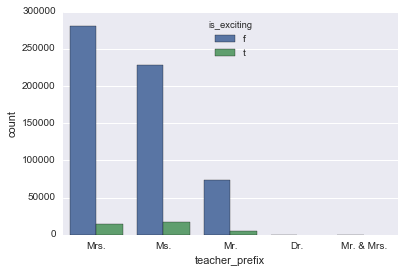

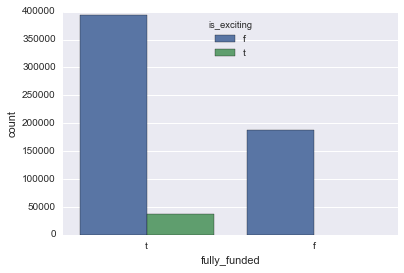

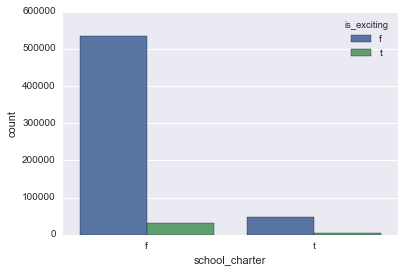

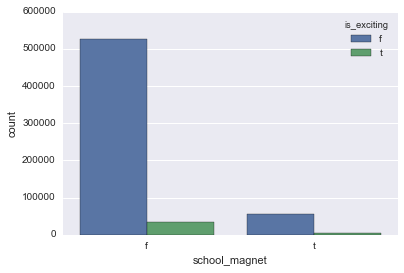

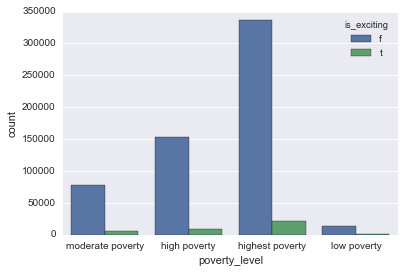

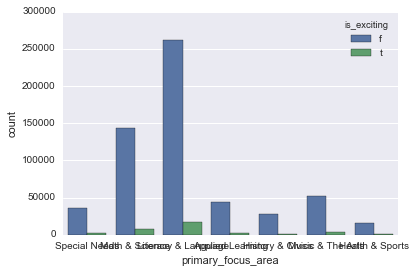

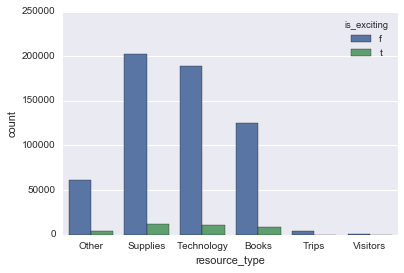

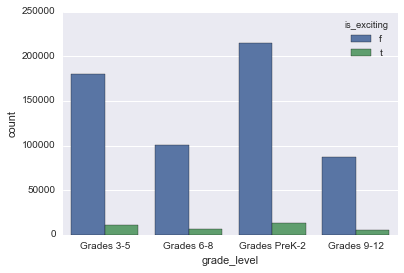

In [40]:
# no clear separation with discrete features
feature = ['teacher_prefix', 'fully_funded', 'school_charter', 'school_magnet', 'poverty_level', 'primary_focus_area', 'resource_type', 'grade_level' ]
summarycount(prooutdf, feature)

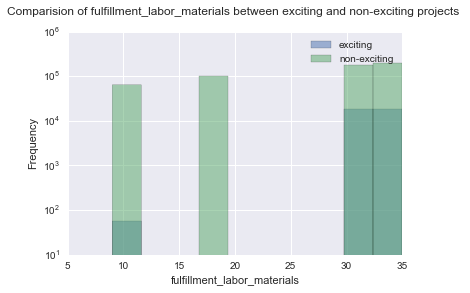

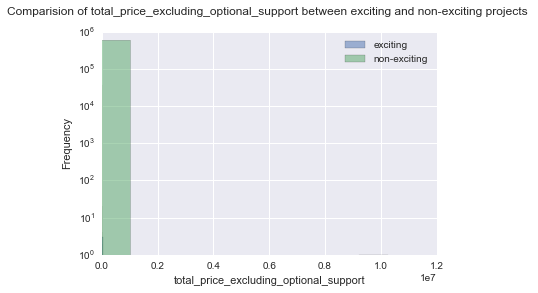

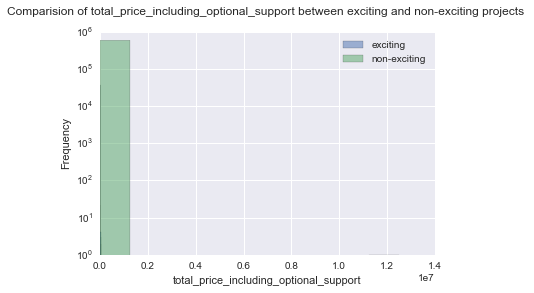

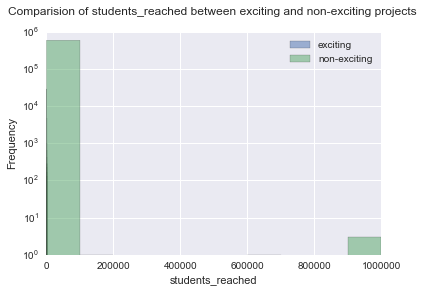

In [77]:
# before dropping outlier
feature2 = ['fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached']
histcompareplots(prooutdf, feature2)

In [81]:
# after dropping outliers for millions of students reached and millions in total price
prooutdf = prooutdf[prooutdf['students_reached'] < 20000]

In [82]:
prooutdf = prooutdf[prooutdf['total_price_excluding_optional_support'] < 20000]

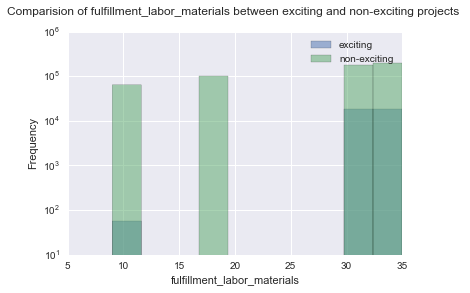

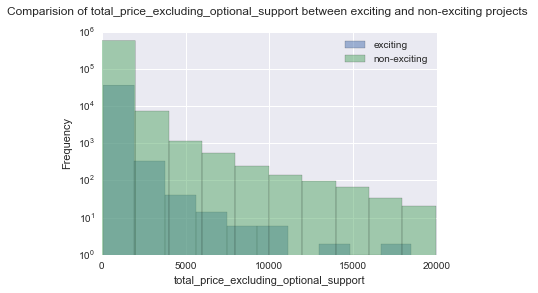

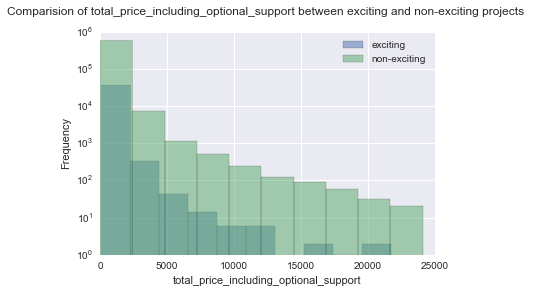

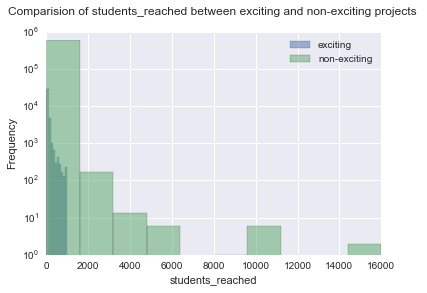

In [83]:
histcompareplots(prooutdf, feature2)

In [88]:
# convert date time from string to datetime
dtdf = prooutdf.copy()
dtdf['date_posted'] = pd.to_datetime(prooutdf['date_posted'])

In [ ]:
dtdf.index = dtdf['date_posted']
del dtdf['date_posted']

In [95]:
dtdf.head(10)

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
date_posted,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-31,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,Du Page,f,f,f,f,f,f,Mrs.,f,f,Special Needs,Special Needs,Literacy,Literacy & Language,Other,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,f,f,t,f,t,t,t,f,80.0,0.0,6.0
2013-12-31,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,Bonneville,f,f,f,f,f,f,Mrs.,f,f,Mathematics,Math & Science,NaN,NaN,Supplies,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,Rockingham,f,f,f,f,f,f,Mrs.,f,f,Environmental Science,Math & Science,Applied Sciences,Math & Science,Technology,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,f,f,f,t,f,f,f,f,NaN,0.0,2.0
2013-12-31,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,Richmond City,f,f,f,f,f,f,Ms.,f,f,Literacy,Literacy & Language,NaN,NaN,Other,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,f,f,f,t,f,f,f,f,NaN,0.0,1.0
2013-12-31,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,Cook,f,t,f,f,f,f,Mr.,f,f,Environmental Science,Math & Science,NaN,NaN,Supplies,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,f,f,t,t,f,f,t,f,50.0,0.0,2.0
2013-12-31,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,NaN,34.193630,-79.769058,Florence,SC,29501.0,urban,Florence School District 1,Florence,f,f,f,f,f,f,Mrs.,f,f,Literature & Writing,Literacy & Language,Mathematics,Math & Science,Supplies,high poverty,Grades PreK-2,30.0,688.11,809.54,22.0,f,f,f,t,f,t,f,f,f,f,0.0,2.0,0.0
2013-12-31,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,2.102990e+11,38.249919,-85.722310,Louisville,KY,40206.0,urban,Jefferson Co School District,Jefferson,f,t,t,f,f,f,Mrs.,f,f,Literature & Writing,Literacy & Language,Mathematics,Math & Science,Technology,highest poverty,Grades PreK-2,30.0,935.16,1100.19,25.0,t,f,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,1.201980e+11,30.507978,-86.132003,Freeport,FL,32439.0,rural,Walton Co School District,Walton,f,f,f,f,f,f,Ms.,f,f,Literacy,Literacy & Language,Mathematics,Math & Science,Technology,highest poverty,Grades PreK-2,30.0,809.32,952.14,17.0,f,f,f,f,t,t,t,

In [118]:
# exciting projects 
exciting = dtdf[dtdf['is_exciting'] == 't']

In [120]:
# view by month number of exiciting projects
monthly = exciting.groupby(pd.TimeGrouper(freq='M'))['is_exciting'].count()

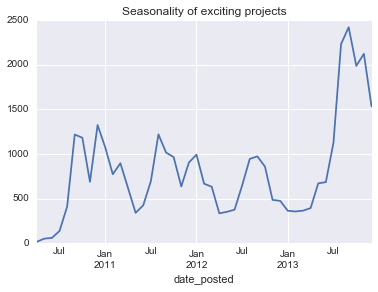

In [122]:
monthly.plot(title = "Seasonality of exciting projects")


## Interesting Data and Caution  

<p>  </p>
<body> 
There are clearly many variables provided in these data to do some sort of prediction task, but let's also keep in mind that the goal is to predict which project is "exciting" to potential donors __at the time of posting__. In other words, some of the variables, such as donor information and donor messages, cannot be known ahead of time and may not make sense to include them for predictive modeling. 
<p> Upon initial observation, missing values/NaN's are present in the data. There are some other weird data, like a negative amount for the minimum donation, negative price for an item and a max of 10 million students reached by one project.

<p></p>

Some useful facts however:  
- only 5.9% of projects are exciting, great class imbalance between exciting and non-exciting project
- 69% of funded projects were exciting, fully funded does not imply project is exciting
- no "exciting" projects before 4/1/2010 and that has to do with certain data not being collected or reported for defining "exciting" project
- clear seasonality in when exciting projects are funded (mostly during the school year with peaks between July and October)

</p>

</body>

### Questions for Project Partner
<p> </p>
1. Does number of page views normalized by duration for fundraising correspond to "exciting" projects? In other words, is higher page views a sign that the project is "exciting"?  
2. If a project is really exceptional but has a lower funding goal and it is fully funded by one generous donor, shouldn't that project be considered "exciting" as well? The definition for "exciting" project may be a bit stringent given that it has to meet certain criteria like getting fully funded. 
3. What happens to projects that are not fully funded but still exceptional?
4. Does the amount of time it took to reach the funding goal normalized by the project cost correspond to "exciting" projects? In other words, are "exciting projects" funded sooner when taking into account the total cost? 


### Modeling

<p> </p>

This part is going to take more than the four hours suggested, so I will briefly sketch my approach if I had more time to implement it.

1. Split the data into training and testing set (set some date threshold), remove projects with missing values in outcomes.
2. Reduce dimensionality by applying logistic regression with L2 regularization as there are many correlated features and it is hard to say which are informative. Incorporate seasonality of exciting projects by including a time penalty for projects submitted later in the academic year.
3. Potentially use information from essays as well, such as essay length or NLP to find active verbs assuming that longer essays or more active verbs make the project sound exciting.
4. Cross validate predictive model and report precision, recall, F1-score and ROC curve. The exciting and not exciting classes are very imbalanced, so the AUC of the ROC curve may not be best for interpreting how good the regression model is performing.